In [ ]:
# Importing the pandas library, which is essential for data manipulation and analysis.
import pandas as pd

# Specifying the file path
file_path = 'Stock_Data.xlsx'

### Benchmark Data

In [ ]:
# Reading Russell 3000 Sheet
# This sheet contains stock data for the Russell 3000 index, which will be used in the SAFT project.
russell_3000_df = pd.read_excel(file_path, sheet_name='Russel_ 3000')

# Drop the specified columns
# The updated russell_3000_df DataFrame now contains only the necessary columns for further analysis.
columns_to_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
russell_3000_df = russell_3000_df.drop(columns=columns_to_drop)

In [ ]:
# Converting the 'Date' to datetime format
russell_3000_df['Date'] = pd.to_datetime(russell_3000_df['Date'], errors='coerce')

# Ensuring the data is sorted by 'Date'
russell_3000_df = russell_3000_df.sort_values(by=['Date'])

# Calculating the daily returns for the index
russell_3000_df['Return'] = russell_3000_df['Close'].pct_change()

# Dropping rows with NaN values in the 'Return' column (the first row will be NaN)
russell_3000_df = russell_3000_df.dropna(subset=['Return'])

# Extracting year from 'Date'
russell_3000_df['Year'] = russell_3000_df['Date'].dt.year

# Calculating average daily return for each year
average_daily_return = russell_3000_df.groupby('Year')['Return'].mean()

# The average daily return is multiplied by 252 (the typical number of trading days in a year) to annualize the return.
average_yearly_return = average_daily_return * 252

# Displaying the results
print("Average Daily Return and Annualized Return for Russell 3000 Index:")
print(average_yearly_return)

Average Daily Return and Annualized Return for Russell 3000 Index:
Year
2019    0.166872
2020    0.233450
2021    0.224532
2022   -0.199187
2023    0.225733
2024    0.250367
Name: Return, dtype: float64


## Optimal Portfolio 2019-2021 Allocation

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Read stock data and Treasury rate data
file_path = 'Stock_Data.xlsx'
stock_data_df = pd.read_excel(file_path, sheet_name='Stock_Data')
treasury_rate_df = pd.read_excel(file_path, sheet_name='Treasury_Rate')

# Convert 'Date' to datetime format
stock_data_df['Date'] = pd.to_datetime(stock_data_df['Date'], errors='coerce')
treasury_rate_df['Date '] = pd.to_datetime(treasury_rate_df['Date '], format='%d/%m/%Y', errors='coerce')

# Filter data for the years 2019, 2020, 2021 and rename
stock_data_2019_2021 = stock_data_df[stock_data_df['Date'].dt.year.isin([2019, 2020, 2021])]
treasury_rate_2019_2021 = treasury_rate_df[treasury_rate_df['Date '].dt.year.isin([2019, 2020, 2021])]

# Calculate daily returns for each stock
stock_data_2019_2021 = stock_data_2019_2021.sort_values(by=['Symbol', 'Date'])
stock_data_2019_2021['Return'] = stock_data_2019_2021.groupby('Symbol')['Close'].pct_change() * 100  # Convert to percentage
stock_data_2019_2021 = stock_data_2019_2021.dropna(subset=['Return'])

# Extract year from 'Date'
stock_data_2019_2021['Year'] = stock_data_2019_2021['Date'].dt.year
treasury_rate_2019_2021['Year'] = treasury_rate_2019_2021['Date '].dt.year

# Calculate the average of the 'Close' column for each year (Treasury rate)
average_close_by_year = treasury_rate_2019_2021.groupby('Year')['Close'].mean()

# Convert yearly Treasury rates to daily rates (assuming 252 trading days per year)
daily_treasury_rate = average_close_by_year / 252

# Create a DataFrame for daily Treasury rates
daily_treasury_df = pd.DataFrame({'Year': daily_treasury_rate.index, 'Daily_Treasury_Rate': daily_treasury_rate.values})

# Merge the daily Treasury rates with the stock data
stock_data_2019_2021 = stock_data_2019_2021.merge(daily_treasury_df, on='Year')

# Subtract the daily Treasury rate from the stock returns to get excess returns
stock_data_2019_2021['Excess_Return'] = stock_data_2019_2021['Return'] - stock_data_2019_2021['Daily_Treasury_Rate']

# Pivot the data to get returns of each stock as columns
returns_df = stock_data_2019_2021.pivot(index='Date', columns='Symbol', values='Excess_Return').dropna()

# Aggregate returns over 2019, 2020, and 2021
aggregate_returns = returns_df[returns_df.index.year.isin([2019, 2020, 2021])]

# Define the objective function for optimization (negative Sharpe ratio)
def negative_sharpe(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized volatility
    sharpe_ratio = portfolio_return / (portfolio_volatility + 1e-10)
    return -sharpe_ratio

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: no short selling, weights between 0 and 1
bounds = tuple((0, 1) for _ in range(aggregate_returns.shape[1]))

# Initial guess: equal distribution
initial_guess = [1 / aggregate_returns.shape[1]] * aggregate_returns.shape[1]

# Optimize the portfolio based on aggregated returns
result = minimize(negative_sharpe, initial_guess, args=(aggregate_returns,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Display the optimal portfolio allocation
optimal_allocation = dict(zip(aggregate_returns.columns, result.x))
print("Optimal portfolio allocation based on aggregated returns (2019-2021) without short selling:")
print(optimal_allocation)

# Calculate the Sharpe ratio of the optimal portfolio
optimal_weights = result.x
portfolio_return = np.sum(aggregate_returns.mean() * optimal_weights) * 252  # Annualized return
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(aggregate_returns.cov() * 252, optimal_weights)))  # Annualized volatility
sharpe_ratio = portfolio_return / (portfolio_volatility + 1e-10)

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

<ipython-input-28-1c1dea94d3ba>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasury_rate_2019_2021['Year'] = treasury_rate_2019_2021['Date '].dt.year


Optimal portfolio allocation based on aggregated returns (2019-2021) without short selling:
{'ADM': 0.0, 'AGCO': 5.6494216930606404e-14, 'BABYF': 1.6029454597902568e-13, 'BG': 0.0, 'BYND': 3.815003528901432e-13, 'CMG': 0.0, 'CNH': 0.0, 'CPNG': 0.28100579921947794, 'DE': 0.0, 'INGR': 0.0, 'K': 0.0, 'LMND': 3.016178555661271e-13, 'LNN': 0.0, 'LWAY': 0.0, 'MFI': 0.000541236827262437, 'NTR': 0.7184529639528416, 'OLO': 1.7642883086741823e-13, 'QSR': 0.0, 'RGF': 4.566048436580532e-13, 'STKL': 0.0, 'TKWY': 6.038948938111743e-14, 'TRMB': 0.0, 'TSN': 0.0, 'TTC': 0.0, 'UBER': 6.669433494521872e-14, 'VFF': 2.8719241772182777e-13, 'WTRH': 2.76745747532848e-13, 'YUM': 0.0}
Sharpe Ratio: 4.2171


In [ ]:
# Convert dictionary to a list of tuples
allocation_list = [(symbol, weight) for symbol, weight in optimal_allocation.items()]

# Create a DataFrame from the list
allocation_df = pd.DataFrame(allocation_list, columns=['Symbol', 'Percentage'])

# Display the DataFrame
print(allocation_df)

   Symbol    Percentage
0     ADM  0.000000e+00
1    AGCO  5.649422e-14
2   BABYF  1.602945e-13
3      BG  0.000000e+00
4    BYND  3.815004e-13
5     CMG  0.000000e+00
6     CNH  0.000000e+00
7    CPNG  2.810058e-01
8      DE  0.000000e+00
9    INGR  0.000000e+00
10      K  0.000000e+00
11   LMND  3.016179e-13
12    LNN  0.000000e+00
13   LWAY  0.000000e+00
14    MFI  5.412368e-04
15    NTR  7.184530e-01
16    OLO  1.764288e-13
17    QSR  0.000000e+00
18    RGF  4.566048e-13
19   STKL  0.000000e+00
20   TKWY  6.038949e-14
21   TRMB  0.000000e+00
22    TSN  0.000000e+00
23    TTC  0.000000e+00
24   UBER  6.669433e-14
25    VFF  2.871924e-13
26   WTRH  2.767457e-13
27    YUM  0.000000e+00


## Optimal Portfolio 2019-2021 2022 Return

In [ ]:
import pandas as pd
import numpy as np

# Assuming stock_data_df contains 'Date', 'Symbol', 'Close' columns
# and optimal_allocation contains the optimal weights for each symbol for 2022

# Filter data for the year 2022
# This filters the stock data for the year 2022 and makes a copy to avoid SettingWithCopyWarning.
stock_data_2022 = stock_data_df[stock_data_df['Date'].dt.year == 2022].copy()

# Initialize dictionaries to store average daily returns and annual returns
avg_daily_returns = {}
annual_returns = {}

# Calculate average daily return for each distinct stock in 2022
for symbol in stock_data_2022['Symbol'].unique():
    # Filter data for the current symbol and make a copy
    symbol_data = stock_data_2022[stock_data_2022['Symbol'] == symbol].copy()

    # Calculate daily returns based on 'Close' column and convert to percentage
    symbol_data['Daily_Return'] = symbol_data['Close'].pct_change() * 100

    # Handle missing values or NaN in daily returns by filling with 0
    symbol_data['Daily_Return'].fillna(0, inplace=True)

    # Skip symbols with any NaN values in daily returns (if any)
    if symbol_data['Daily_Return'].isnull().any():
        continue

    # Calculate average daily return
    avg_daily_return = symbol_data['Daily_Return'].mean()
    avg_daily_returns[symbol] = avg_daily_return

    # Annualize the average daily return (assuming 252 trading days)
    annual_return = avg_daily_return * 252
    annual_returns[symbol] = annual_return

    # Calculate daily returns variance
    daily_returns_var = symbol_data['Daily_Return'].var()  # Calculate variance of daily returns
    symbol_data['daily_returns_var_2022'] = daily_returns_var  # Add variance as a new column

    # Update stock_data_2022 with symbol_data including daily_returns_var_2022
    stock_data_2022.loc[stock_data_2022['Symbol'] == symbol, 'Daily_Return'] = symbol_data['Daily_Return']
    stock_data_2022.loc[stock_data_2022['Symbol'] == symbol, 'daily_returns_var_2022'] = symbol_data['daily_returns_var_2022']

# Convert dictionaries to DataFrames
# Create DataFrames for average daily returns and annual returns.
avg_daily_returns_df = pd.DataFrame.from_dict(avg_daily_returns, orient='index', columns=['Average_Daily_Return'])
annual_returns_df = pd.DataFrame.from_dict(annual_returns, orient='index', columns=['Annual_Return'])

# Multiply annual returns by optimal allocation percentages
# This creates a Series from optimal allocation and calculates weighted annual returns.
optimal_allocation_series = pd.Series(optimal_allocation)
weighted_annual_returns = annual_returns_df['Annual_Return'] * optimal_allocation_series

# Calculate the portfolio return based on optimal allocation
# This calculates the portfolio return for 2022.
stock_data_2022['portfolio_return_2022'] = np.sum(weighted_annual_returns)

# Display the annual returns and weighted returns for each stock
print("Weighted Annual Returns for each stock in 2022:")
print(weighted_annual_returns)

# Sum of weighted annual returns for the portfolio
weighted_annual_returns_sum = weighted_annual_returns.sum()
print(f"Sum of Weighted Annual Returns for the portfolio in 2022: {weighted_annual_returns_sum:.2f}")

# Calculate the portfolio's annual volatility
# Pivot the data to get daily returns of each stock as columns for 2022.
returns_df_2022 = stock_data_2022.pivot(index='Date', columns='Symbol', values='Daily_Return').dropna()

# Calculate the covariance matrix of daily returns and annualize it.
cov_matrix_annual = returns_df_2022.cov() * 252

# Calculate the portfolio volatility
# This calculates the annualized portfolio volatility.
portfolio_volatility = np.sqrt(np.dot(optimal_allocation_series.T, np.dot(cov_matrix_annual, optimal_allocation_series)))
print(f"Portfolio Volatility (Annualized): {portfolio_volatility:.2f}")


Weighted Annual Returns for each stock in 2022:
ADM      0.000000e+00
AGCO     1.446692e-12
BABYF   -8.195310e-12
BG       0.000000e+00
BYND    -4.700350e-11
CMG     -0.000000e+00
CNH      0.000000e+00
CPNG    -9.155905e+00
DE       0.000000e+00
INGR     0.000000e+00
K       -0.000000e+00
LMND    -2.269890e-11
LNN      0.000000e+00
LWAY     0.000000e+00
MFI      1.347284e-02
NTR      5.038307e+00
OLO     -1.595147e-11
QSR      0.000000e+00
RGF      1.051608e-11
STKL     0.000000e+00
TKWY    -3.278104e-12
TRMB    -0.000000e+00
TSN     -0.000000e+00
TTC      0.000000e+00
UBER    -2.499504e-12
VFF     -3.932007e-11
WTRH    -7.702318e-11
YUM     -0.000000e+00
dtype: float64
Sum of Weighted Annual Returns for the portfolio in 2022: -4.10
Portfolio Volatility (Annualized): 43.77


In [ ]:
# Calculate the average of the 'Close' column for each year (Treasury rate)
treasury_rate_2022 = treasury_rate_df[treasury_rate_df['Date '].dt.year == 2022]['Close'].mean()

# Convert yearly Treasury rate to daily rate (assuming 252 trading days per year)
daily_treasury_rate_2022 = treasury_rate_2022 / 252


# Calculate the Sharpe ratio (assuming risk-free rate is the daily treasury rate for 2022 annualized)
risk_free_rate_2022 = daily_treasury_rate_2022 * 252
sharpe_ratio = (weighted_annual_returns_sum - risk_free_rate_2022) / portfolio_volatility
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: -0.1612


In [ ]:
import pandas as pd
import numpy as np

# Assuming stock_data_df contains 'Date', 'Symbol', 'Close' columns and optimal_allocation contains the optimal weights for each symbol for 2022
# Filter data for the year 2022
# This filters the stock data for the year 2022 and makes a copy to avoid SettingWithCopyWarning.
stock_data_2022 = stock_data_df[stock_data_df['Date'].dt.year == 2022].copy()

# Ensure optimal_allocation is a dictionary with symbols as keys and allocation percentages as values
# Initialize a dictionary to store average daily returns
avg_daily_returns = {}

# Calculate average daily return for each distinct stock in 2022
for symbol in stock_data_2022['Symbol'].unique():
    # Filter data for the current symbol and make a copy
    symbol_data = stock_data_2022[stock_data_2022['Symbol'] == symbol].copy()

    # Calculate daily returns based on 'Close' column and convert to percentage
    symbol_data['Daily_Return'] = symbol_data['Close'].pct_change() * 100

    # Handle missing values or NaN in daily returns by filling with 0
    symbol_data['Daily_Return'].fillna(0, inplace=True)

    # Calculate average daily return
    avg_daily_return = symbol_data['Daily_Return'].mean()
    avg_daily_returns[symbol] = avg_daily_return

    # Multiply daily returns by optimal allocation percentage for the stock
    # This calculates the daily returns weighted by the optimal allocation for the stock.
    symbol_data['2022 Daily Returns'] = symbol_data['Daily_Return'] * optimal_allocation.get(symbol, 0)

    # Update stock_data_2022 with symbol_data including 2022 Daily Returns
    # This ensures that the '2022 Daily Returns' column in stock_data_2022 is updated with the calculated values.
    stock_data_2022.loc[stock_data_2022['Symbol'] == symbol, '2022 Daily Returns'] = symbol_data['2022 Daily Returns']

# Convert avg_daily_returns to a DataFrame
# This converts the avg_daily_returns dictionary to a DataFrame for better readability and analysis.
avg_daily_returns_df = pd.DataFrame.from_dict(avg_daily_returns, orient='index', columns=['Average_Daily_Return'])

# Display the average daily returns for each stock
print("Average Daily Returns for each stock in 2022:")
print(avg_daily_returns_df)

# Display the updated DataFrame with 2022 Daily Returns based on Allocation
print("\nUpdated DataFrame with 2022 Daily Returns based on Allocation:")
print(stock_data_2022)


Average Daily Returns for each stock in 2022:
       Average_Daily_Return
BYND              -0.488917
TSN               -0.122309
MFI                0.098780
ADM                0.144073
INGR               0.015496
STKL               0.144200
BABYF             -0.202883
LWAY               0.132833
BG                 0.047087
K                 -0.028477
TRMB              -0.179232
DE                 0.105542
AGCO               0.101618
CNH                0.015892
TTC                0.067822
LNN                0.047245
VFF               -0.543301
NTR                0.027828
WTRH              -1.104434
UBER              -0.148718
OLO               -0.358782
CPNG              -0.129296
TKWY              -0.215408
QSR                0.042112
YUM               -0.013985
LMND              -0.298640
RGF                0.091393
CMG               -0.045880

Updated DataFrame with 2022 Daily Returns based on Allocation:
            Date       Open       High        Low      Close  Adj Close  \
633

In [ ]:
# Group by 'Date' and sum the '2022 Daily Returns' for each date
daily_total_returns_2022 = stock_data_2022.groupby('Date')['2022 Daily Returns'].sum().reset_index()

# Rename the columns for clarity
daily_total_returns_2022.columns = ['Date', 'Daily Total Returns 2022']

# Display the resultant table
print(daily_total_returns_2022)


          Date  Daily Total Returns 2022
0   2022-01-02                 -0.000052
1   2022-01-03                 -0.000856
2   2022-01-04                 -6.366290
3   2022-01-05                 -2.683124
4   2022-01-06                 -0.654288
..         ...                       ...
284 2022-12-23                  0.305254
285 2022-12-27                  0.395297
286 2022-12-28                 -2.264996
287 2022-12-29                  0.350497
288 2022-12-30                 -0.237097

[289 rows x 2 columns]



## Optimal Portfolio 2022 Allocation

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Read stock data and Treasury rate data
file_path = 'Stock_Data.xlsx'
stock_data_df = pd.read_excel(file_path, sheet_name='Stock_Data')
treasury_rate_df = pd.read_excel(file_path, sheet_name='Treasury_Rate')

# Convert 'Date' to datetime format
stock_data_df['Date'] = pd.to_datetime(stock_data_df['Date'], errors='coerce')
treasury_rate_df['Date '] = pd.to_datetime(treasury_rate_df['Date '], format='%d/%m/%Y', errors='coerce')

# Filter data for the year 2022 only
stock_data_2022 = stock_data_df[stock_data_df['Date'].dt.year == 2022]

# Calculate daily returns for each stock in 2022
stock_data_2022 = stock_data_2022.sort_values(by=['Symbol', 'Date'])
stock_data_2022['Return'] = stock_data_2022.groupby('Symbol')['Close'].pct_change() * 100  # Convert to percentage
stock_data_2022 = stock_data_2022.dropna(subset=['Return'])

# Extract year from 'Date'
stock_data_2022['Year'] = stock_data_2022['Date'].dt.year

# Calculate the average of the 'Close' column for each year (Treasury rate)
treasury_rate_2022 = treasury_rate_df[treasury_rate_df['Date '].dt.year == 2022]['Close'].mean()

# Convert yearly Treasury rate to daily rate (assuming 252 trading days per year)
daily_treasury_rate_2022 = treasury_rate_2022 / 252

# Merge the daily Treasury rate with the stock data for 2022
stock_data_2022['Daily_Treasury_Rate'] = daily_treasury_rate_2022

# Subtract the daily Treasury rate from the stock returns to get excess returns for 2022
stock_data_2022['Excess_Return'] = stock_data_2022['Return'] - stock_data_2022['Daily_Treasury_Rate']

# Pivot the data to get returns of each stock as columns for 2022
returns_df_2022 = stock_data_2022.pivot(index='Date', columns='Symbol', values='Excess_Return').dropna()

# Define the objective function for optimization (negative Sharpe ratio)
def negative_sharpe(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized volatility
    sharpe_ratio = portfolio_return / (portfolio_volatility + 1e-10)
    return -sharpe_ratio

# Aggregate returns for 2022
aggregate_returns_2022 = returns_df_2022

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: no short selling, weights between 0 and 1
bounds = tuple((0, 1) for _ in range(aggregate_returns_2022.shape[1]))

# Initial guess: equal distribution
initial_guess = [1 / aggregate_returns_2022.shape[1]] * aggregate_returns_2022.shape[1]

# Optimize the portfolio based on aggregated returns for 2022
result = minimize(negative_sharpe, initial_guess, args=(aggregate_returns_2022,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Display the optimal portfolio allocation for 2022
optimal_allocation_2022 = dict(zip(aggregate_returns_2022.columns, result.x))
print("Optimal portfolio allocation based on aggregated returns for 2022 without short selling:")
print(optimal_allocation_2022)

# Calculate the expected annual return of the portfolio
portfolio_return = np.sum(aggregate_returns_2022.mean() * result.x) * 252

# Calculate the annual volatility of the portfolio
portfolio_volatility = np.sqrt(np.dot(result.x.T, np.dot(aggregate_returns_2022.cov() * 252, result.x)))

# Calculate the Sharpe ratio (assuming risk-free rate is the daily treasury rate for 2022 annualized)
risk_free_rate_2022 = daily_treasury_rate_2022 * 252
sharpe_ratio = (portfolio_return - risk_free_rate_2022) / portfolio_volatility

# Display the Sharpe ratio
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


<ipython-input-34-332b331f109c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_2022['Year'] = stock_data_2022['Date'].dt.year
<ipython-input-34-332b331f109c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_2022['Daily_Treasury_Rate'] = daily_treasury_rate_2022
<ipython-input-34-332b331f109c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Optimal portfolio allocation based on aggregated returns for 2022 without short selling:
{'ADM': 0.4643268840210154, 'AGCO': 0.0, 'BABYF': 0.0, 'BG': 0.0, 'BYND': 3.245395714911596e-14, 'CMG': 0.0, 'CNH': 0.0, 'CPNG': 0.0, 'DE': 0.0, 'INGR': 0.0, 'K': 0.0, 'LMND': 2.382160270035043e-14, 'LNN': 0.0, 'LWAY': 0.2167559825081279, 'MFI': 0.1269275828196954, 'NTR': 0.0, 'OLO': 1.4762564976730488e-14, 'QSR': 0.0, 'RGF': 0.09300482464387111, 'STKL': 0.09898472600741098, 'TKWY': 1.3995694794072255e-16, 'TRMB': 0.0, 'TSN': 0.0, 'TTC': 0.0, 'UBER': 3.915865052924467e-15, 'VFF': 1.946082242798235e-14, 'WTRH': 1.0229106831477554e-13, 'YUM': 0.0}
Sharpe Ratio: 2.1204


## Optimal Portfolio 2022's 2023 Return

In [ ]:
import pandas as pd
import numpy as np

# Assuming stock_data_df contains 'Date', 'Symbol', 'Close' columns
# and optimal_allocation_2022 contains the optimal weights for each symbol for 2022

# Filter data for the year 2023
stock_data_2023 = stock_data_df[stock_data_df['Date'].dt.year == 2023].copy()  # Make a copy to avoid SettingWithCopyWarning

# Initialize dictionaries to store average daily returns and annual returns
avg_daily_returns = {}
annual_returns = {}

# Calculate average daily return for each distinct stock in 2023
for symbol in stock_data_2023['Symbol'].unique():
    # Filter data for the current symbol
    symbol_data = stock_data_2023[stock_data_2023['Symbol'] == symbol].copy()  # Make a copy to avoid SettingWithCopyWarning

    # Calculate daily returns based on 'Close' column
    symbol_data['Daily_Return'] = symbol_data['Close'].pct_change() * 100

    # Handle missing values or NaN in daily returns
    symbol_data['Daily_Return'].fillna(0, inplace=True)

    # Calculate average daily return
    avg_daily_return = symbol_data['Daily_Return'].mean()
    avg_daily_returns[symbol] = avg_daily_return

    # Annualize the average daily return (assuming 252 trading days)
    annual_return = avg_daily_return * 252
    annual_returns[symbol] = annual_return

# Convert dictionaries to DataFrames
avg_daily_returns_df = pd.DataFrame.from_dict(avg_daily_returns, orient='index', columns=['Average_Daily_Return'])
annual_returns_df = pd.DataFrame.from_dict(annual_returns, orient='index', columns=['Annual_Return'])

# Convert optimal_allocation_2022 to a Series (if it's not already)
optimal_allocation_series = pd.Series(optimal_allocation_2022)

# Multiply annual returns by optimal allocation percentages
weighted_annual_returns = annual_returns_df['Annual_Return'] * optimal_allocation_series

# Display the annual returns and weighted returns for each stock
print("Weighted Annual Returns for each stock in 2023:")
print(weighted_annual_returns)

# Sum of Weighted Annual Returns
weighted_annual_returns_sum = weighted_annual_returns.sum()

print(f"\nSum of Weighted Annual Returns for each stock in 2023: {weighted_annual_returns_sum:.2f}%")

# Calculate portfolio return for 2023
portfolio_return_2023 = weighted_annual_returns_sum

# Calculate portfolio volatility for 2023
# Calculate daily returns for each stock in 2023
stock_data_2023.sort_values(by=['Symbol', 'Date'], inplace=True)
stock_data_2023['Daily_Return'] = stock_data_2023.groupby('Symbol')['Close'].pct_change() * 100

# Drop rows with NaN values in Daily_Return
stock_data_2023.dropna(subset=['Daily_Return'], inplace=True)

# Pivot the data to get daily returns of each stock as columns for 2023
returns_df_2023 = stock_data_2023.pivot(index='Date', columns='Symbol', values='Daily_Return').dropna()

# Calculate the covariance matrix of daily returns and annualize it
cov_matrix_annual = returns_df_2023.cov() * 252

# Calculate the portfolio volatility
portfolio_volatility_2023 = np.sqrt(np.dot(optimal_allocation_series.T, np.dot(cov_matrix_annual, optimal_allocation_series)))

# Calculate risk-free rate for 2023
treasury_rate_2023 = treasury_rate_df[treasury_rate_df['Date '].dt.year == 2023]['Close'].mean()
risk_free_rate_2023 = treasury_rate_2023 / 252  # Daily rate, annualized

# Calculate Sharpe ratio
sharpe_ratio_2023 = (portfolio_return_2023 - risk_free_rate_2023) / portfolio_volatility_2023

# Display the Sharpe ratio
print(f"\nSharpe Ratio for the portfolio in 2023: {sharpe_ratio_2023:.4f}")

Weighted Annual Returns for each stock in 2023:
ADM     -8.966957e+00
AGCO    -0.000000e+00
BABYF    0.000000e+00
BG       0.000000e+00
BYND    -6.329132e-14
CMG      0.000000e+00
CNH     -0.000000e+00
CPNG     0.000000e+00
DE      -0.000000e+00
INGR     0.000000e+00
K        0.000000e+00
LMND     1.208266e-12
LNN     -0.000000e+00
LWAY     2.577656e+01
MFI      5.738579e-01
NTR     -0.000000e+00
OLO      2.151246e-14
QSR      0.000000e+00
RGF     -1.132108e+01
STKL    -2.702819e+00
TKWY    -3.831895e-15
TRMB     0.000000e+00
TSN     -0.000000e+00
TTC     -0.000000e+00
UBER     3.759537e-13
VFF     -3.252485e-13
WTRH    -6.887484e-12
YUM      0.000000e+00
dtype: float64

Sum of Weighted Annual Returns for each stock in 2023: 3.36%

Sharpe Ratio for the portfolio in 2023: 0.1262


In [ ]:
import pandas as pd

# Assuming stock_data_df contains 'Date', 'Symbol', 'Close' columns
# and optimal_allocation_2022 contains the optimal weights for each symbol for 2022

# Filter data for the year 2023
stock_data_2023 = stock_data_df[stock_data_df['Date'].dt.year == 2023].copy()  # Make a copy to avoid SettingWithCopyWarning

# Ensure optimal_allocation_2022 is a dictionary with symbols as keys and allocation percentages as values

# Initialize a dictionary to store average daily returns
avg_daily_returns = {}

# Calculate average daily return for each distinct stock in 2023
for symbol in stock_data_2023['Symbol'].unique():
    # Filter data for the current symbol
    symbol_data = stock_data_2023[stock_data_2023['Symbol'] == symbol].copy()  # Make a copy of the filtered data

    # Calculate daily returns based on 'Close' column
    symbol_data['Daily_Return'] = symbol_data['Close'].pct_change() * 100

    # Handle missing values or NaN in daily returns
    symbol_data['Daily_Return'].fillna(0, inplace=True)

    # Calculate average daily return
    avg_daily_return = symbol_data['Daily_Return'].mean()
    avg_daily_returns[symbol] = avg_daily_return

    # Multiply daily returns by optimal allocation percentage for the stock in 2022
    symbol_data['2023 Daily Returns'] = symbol_data['Daily_Return'] * optimal_allocation_2022.get(symbol, 0)

    # Update stock_data_2023 with symbol_data including 2023 Daily Returns
    stock_data_2023.loc[stock_data_2023['Symbol'] == symbol, '2023 Daily Returns'] = symbol_data['2023 Daily Returns']

# Convert avg_daily_returns to a DataFrame
avg_daily_returns_df = pd.DataFrame.from_dict(avg_daily_returns, orient='index', columns=['Average_Daily_Return'])

# Display the average daily returns for each stock
print("Average Daily Returns for each stock in 2023:")
print(avg_daily_returns_df)

# Display the updated DataFrame with 2023 Daily Returns based on Allocation
print("\nUpdated DataFrame with 2023 Daily Returns based on Allocation:")
print(stock_data_2023[['Date', 'Symbol', 'Close', '2023 Daily Returns']])


Average Daily Returns for each stock in 2023:
       Average_Daily_Return
BYND              -0.007739
TSN               -0.051185
MFI                0.017941
ADM               -0.076634
INGR               0.051017
STKL              -0.108355
BABYF              0.079239
LWAY               0.471904
BG                 0.037774
K                  0.076519
TRMB               0.039268
DE                -0.009134
AGCO              -0.030776
CNH               -0.091036
TTC               -0.048197
LNN               -0.051672
VFF               -0.066321
NTR               -0.075055
WTRH              -0.267191
UBER               0.380983
OLO                0.005783
CPNG               0.063310
TKWY              -0.108647
QSR                0.083569
YUM                0.016660
LMND               0.201276
RGF               -0.483039
CMG                0.218076

Updated DataFrame with 2023 Daily Returns based on Allocation:
            Date Symbol      Close  2023 Daily Returns
884   2023-01-03   BYND

In [ ]:
# Group by 'Date' and sum the '2022 Daily Returns' for each date
daily_total_returns_2023 = stock_data_2023.groupby('Date')['2023 Daily Returns'].sum().reset_index()

# Rename the columns for clarity
daily_total_returns_2023.columns = ['Date', 'Daily Total Returns 2023']

# Display the resultant table
print(daily_total_returns_2023)


          Date  Daily Total Returns 2023
0   2023-01-02                 -0.197048
1   2023-01-03                  0.059397
2   2023-01-04                 -1.601650
3   2023-01-05                 -1.439732
4   2023-01-06                  0.967229
..         ...                       ...
285 2023-12-22                  0.761613
286 2023-12-26                  1.092901
287 2023-12-27                  0.348070
288 2023-12-28                 -0.655028
289 2023-12-29                  0.429445

[290 rows x 2 columns]


## Optimal Portflio 2023 Allocation

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Assuming stock_data_df contains 'Date', 'Symbol', 'Close' columns
# and treasury_rate_df contains 'Date ', 'Close' columns

# Read stock data and Treasury rate data
file_path = 'Stock_Data.xlsx'
stock_data_df = pd.read_excel(file_path, sheet_name='Stock_Data')
treasury_rate_df = pd.read_excel(file_path, sheet_name='Treasury_Rate')

# Convert 'Date' to datetime format
stock_data_df['Date'] = pd.to_datetime(stock_data_df['Date'], errors='coerce')
treasury_rate_df['Date '] = pd.to_datetime(treasury_rate_df['Date '], format='%d/%m/%Y', errors='coerce')

# Filter data for the year 2023 only
stock_data_2023 = stock_data_df[stock_data_df['Date'].dt.year == 2023]

# Calculate daily returns for each stock in 2023
stock_data_2023 = stock_data_2023.sort_values(by=['Symbol', 'Date'])
stock_data_2023['Return'] = stock_data_2023.groupby('Symbol')['Close'].pct_change() * 100  # Convert to percentage
stock_data_2023 = stock_data_2023.dropna(subset=['Return'])

# Extract year from 'Date'
stock_data_2023['Year'] = stock_data_2023['Date'].dt.year

# Calculate the average of the 'Close' column for 2023 (Treasury rate)
treasury_rate_2023 = treasury_rate_df[treasury_rate_df['Date '].dt.year == 2023]['Close'].mean()

# Convert yearly Treasury rate to daily rate (assuming 252 trading days per year)
daily_treasury_rate_2023 = treasury_rate_2023 / 252

# Merge the daily Treasury rate with the stock data for 2023
stock_data_2023['Daily_Treasury_Rate'] = daily_treasury_rate_2023

# Subtract the daily Treasury rate from the stock returns to get excess returns for 2023
stock_data_2023['Excess_Return'] = stock_data_2023['Return'] - stock_data_2023['Daily_Treasury_Rate']

# Pivot the data to get returns of each stock as columns for 2023
returns_df_2023 = stock_data_2023.pivot(index='Date', columns='Symbol', values='Excess_Return').dropna()

# Aggregate returns for 2023
aggregate_returns_2023 = returns_df_2023

# Define the objective function for optimization (negative Sharpe ratio)
def negative_sharpe(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized volatility
    sharpe_ratio = portfolio_return / (portfolio_volatility + 1e-10)
    return -sharpe_ratio

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: no short selling, weights between 0 and 1
bounds = tuple((0, 1) for _ in range(aggregate_returns_2023.shape[1]))

# Initial guess: equal distribution
initial_guess = [1 / aggregate_returns_2023.shape[1]] * aggregate_returns_2023.shape[1]

# Optimize the portfolio based on aggregated returns for 2023
result = minimize(negative_sharpe, initial_guess, args=(aggregate_returns_2023,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Display the optimal portfolio allocation for 2023
optimal_allocation_2023 = dict(zip(aggregate_returns_2023.columns, result.x))
print("Optimal portfolio allocation based on aggregated returns for 2023 without short selling:")
print(optimal_allocation_2023)

# Calculate portfolio return for 2023
portfolio_return_2023 = np.sum(aggregate_returns_2023.mean() * result.x) * 252

# Calculate portfolio volatility for 2023
portfolio_volatility_2023 = np.sqrt(np.dot(result.x.T, np.dot(aggregate_returns_2023.cov() * 252, result.x)))

# Calculate risk-free rate for 2023
treasury_rate_2023 = treasury_rate_df[treasury_rate_df['Date '].dt.year == 2023]['Close'].mean()
risk_free_rate_2023 = treasury_rate_2023 / 252  # Daily rate, annualized

# Calculate Sharpe ratio
sharpe_ratio_2023 = (portfolio_return_2023 - risk_free_rate_2023) / portfolio_volatility_2023

# Display the Sharpe ratio
print(f"\nSharpe Ratio for the portfolio in 2023: {sharpe_ratio_2023:.4f}")


Optimal portfolio allocation based on aggregated returns for 2023 without short selling:
{'ADM': 0.0, 'AGCO': 0.0, 'BABYF': 0.0, 'BG': 0.0, 'BYND': 2.1508313548293685e-14, 'CMG': 0.3501937321862249, 'CNH': 2.3423026017132084e-15, 'CPNG': 0.0, 'DE': 0.0, 'INGR': 0.01174246281930507, 'K': 0.068136916292794, 'LMND': 3.100374792240777e-14, 'LNN': 0.0, 'LWAY': 0.0892650833434959, 'MFI': 0.0030646027211338597, 'NTR': 0.0, 'OLO': 8.974651466339639e-15, 'QSR': 0.08472360282692463, 'RGF': 7.8447763066384e-15, 'STKL': 0.03094172399542111, 'TKWY': 2.6335030806995192e-14, 'TRMB': 0.0, 'TSN': 0.0, 'TTC': 0.0, 'UBER': 0.36193187581465164, 'VFF': 1.6595063514890357e-14, 'WTRH': 4.010041332690103e-14, 'YUM': 0.0}

Sharpe Ratio for the portfolio in 2023: 2.8742


## Optimal Portfolio 2023's 2024 Return

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Assuming stock_data_df contains 'Date', 'Symbol', 'Close' columns
# and optimal_allocation_2024 contains the optimal weights for each symbol for 2024

# Filter data for the year 2024
stock_data_2024 = stock_data_df[stock_data_df['Date'].dt.year == 2024]

# Initialize dictionaries to store average daily returns and annual returns
avg_daily_returns_2024 = {}
annual_returns_2024 = {}

# Calculate average daily return for each distinct stock in 2024
for symbol in stock_data_2024['Symbol'].unique():
    # Filter data for the current symbol
    symbol_data_2024 = stock_data_2024[stock_data_2024['Symbol'] == symbol]

    # Calculate daily returns based on 'Close' column
    symbol_data_2024['Daily_Return'] = symbol_data_2024['Close'].pct_change() * 100

    # Handle missing values or NaN in daily returns
    symbol_data_2024['Daily_Return'].fillna(0, inplace=True)

    # Skip NaN values in daily returns
    if symbol_data_2024['Daily_Return'].isnull().any():
        continue

    # Calculate average daily return
    avg_daily_return_2024 = symbol_data_2024['Daily_Return'].mean()
    avg_daily_returns_2024[symbol] = avg_daily_return_2024

    # Annualize the average daily return (assuming 252 trading days)
    annual_return_2024 = avg_daily_return_2024 * 252
    annual_returns_2024[symbol] = annual_return_2024

# Convert dictionaries to DataFrames
avg_daily_returns_df_2024 = pd.DataFrame.from_dict(avg_daily_returns_2024, orient='index', columns=['Average_Daily_Return'])
annual_returns_df_2024 = pd.DataFrame.from_dict(annual_returns_2024, orient='index', columns=['Annual_Return'])

# Convert optimal_allocation_2024 to a Series (if it's not already)
optimal_allocation_series_2024 = pd.Series(optimal_allocation_2023)

# Multiply annual returns by optimal allocation percentages
weighted_annual_returns_2024 = annual_returns_df_2024['Annual_Return'] * optimal_allocation_series_2024

# Display the annual returns and weighted returns for each stock
print("Weighted Annual Returns for each stock in 2024:")
print(weighted_annual_returns_2024)

# Sum of Weighted Annual Returns
weighted_annual_returns_sum_2024 = weighted_annual_returns_2024.sum()

print(f"\nSum of Weighted Annual Returns for each stock in 2024: {weighted_annual_returns_sum_2024:.2f}%")

# Calculate portfolio return for 2024
portfolio_return_2024 = weighted_annual_returns_sum_2024

# Calculate daily returns for the portfolio in 2024
stock_data_2024 = stock_data_2024.sort_values(by=['Symbol', 'Date'])
stock_data_2024['Daily_Return'] = stock_data_2024.groupby('Symbol')['Close'].pct_change() * 100

# Drop NaN values
stock_data_2024 = stock_data_2024.dropna(subset=['Daily_Return'])

# Pivot data to get returns of each stock as columns for 2024
returns_df_2024 = stock_data_2024.pivot(index='Date', columns='Symbol', values='Daily_Return').dropna()

# Calculate portfolio volatility for 2024
portfolio_volatility_2024 = np.sqrt(np.dot(optimal_allocation_series_2024.T, np.dot(returns_df_2024.cov() * 252, optimal_allocation_series_2024)))

# Assuming you have already calculated `portfolio_return_2024` as `weighted_annual_returns_sum_2024`

# Calculate risk-free rate for 2024 (you need to adjust this based on your data)
# Example here assumes you have a Treasury rate data similar to previous examples
treasury_rate_2024 = treasury_rate_df[treasury_rate_df['Date '].dt.year == 2024]['Close'].mean()
risk_free_rate_2024 = treasury_rate_2024 / 252  # Daily rate, annualized

# Calculate Sharpe ratio for 2024
sharpe_ratio_2024 = (portfolio_return_2024 - risk_free_rate_2024) / portfolio_volatility_2024

# Display the Sharpe ratio for 2024
print(f"\nSharpe Ratio for the portfolio in 2024: {sharpe_ratio_2024:.4f}")


Weighted Annual Returns for each stock in 2024:
ADM     -0.000000e+00
AGCO    -0.000000e+00
BABYF    0.000000e+00
BG       0.000000e+00
BYND    -2.526904e-13
CMG      2.484540e+01
CNH     -7.781943e-14
CPNG     0.000000e+00
DE      -0.000000e+00
INGR     1.204262e-01
K        1.691548e-01
LMND     5.868105e-13
LNN     -0.000000e+00
LWAY     2.899710e+00
MFI      6.451078e-02
NTR     -0.000000e+00
OLO     -3.108814e-13
QSR     -1.320449e+00
RGF     -8.572362e-13
STKL     1.481555e-01
TKWY    -8.145092e-13
TRMB     0.000000e+00
TSN      0.000000e+00
TTC      0.000000e+00
UBER     1.838828e+01
VFF      1.543798e-12
WTRH    -1.730975e-12
YUM      0.000000e+00
dtype: float64

Sum of Weighted Annual Returns for each stock in 2024: 45.32%

Sharpe Ratio for the portfolio in 2024: 2.0078


<ipython-input-39-a3d5da973a6c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_data_2024['Daily_Return'] = symbol_data_2024['Close'].pct_change() * 100
<ipython-input-39-a3d5da973a6c>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_data_2024['Daily_Return'].fillna(0, inplace=True)
<ipython-input-39-a3d5da973a6c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
import pandas as pd

# Assuming stock_data_df contains 'Date', 'Symbol', 'Close' columns
# and optimal_allocation_2023 contains the optimal weights for each symbol for 2023

# Filter data for the year 2024
stock_data_2024 = stock_data_df[stock_data_df['Date'].dt.year == 2024].copy()  # Make a copy to avoid SettingWithCopyWarning

# Ensure optimal_allocation_2023 is a dictionary with symbols as keys and allocation percentages as values

# Initialize a dictionary to store average daily returns
avg_daily_returns = {}

# Calculate average daily return for each distinct stock in 2024
for symbol in stock_data_2024['Symbol'].unique():
    # Filter data for the current symbol
    symbol_data = stock_data_2024[stock_data_2024['Symbol'] == symbol].copy()  # Make a copy of the filtered data

    # Calculate daily returns based on 'Close' column
    symbol_data['Daily_Return'] = symbol_data['Close'].pct_change() * 100

    # Handle missing values or NaN in daily returns
    symbol_data['Daily_Return'].fillna(0, inplace=True)

    # Calculate average daily return
    avg_daily_return = symbol_data['Daily_Return'].mean()
    avg_daily_returns[symbol] = avg_daily_return

    # Multiply daily returns by optimal allocation percentage for the stock in 2023
    symbol_data['2024 Daily Returns'] = symbol_data['Daily_Return'] * optimal_allocation_2023.get(symbol, 0)

    # Update stock_data_2024 with symbol_data including 2024 Daily Returns
    stock_data_2024.loc[stock_data_2024['Symbol'] == symbol, '2024 Daily Returns'] = symbol_data['2024 Daily Returns']

# Convert avg_daily_returns to a DataFrame
avg_daily_returns_df = pd.DataFrame.from_dict(avg_daily_returns, orient='index', columns=['Average_Daily_Return'])

# Display the average daily returns for each stock
print("Average Daily Returns for each stock in 2024:")
print(avg_daily_returns_df)

# Display the updated DataFrame with 2024 Daily Returns based on Allocation
print("\nUpdated DataFrame with 2024 Daily Returns based on Allocation:")
print(stock_data_2024[['Date', 'Symbol', 'Close', '2024 Daily Returns']])


Average Daily Returns for each stock in 2024:
       Average_Daily_Return
BYND              -0.046621
TSN                0.032080
MFI                0.083533
ADM               -0.110351
INGR               0.040697
STKL               0.019001
BABYF              0.042337
LWAY               0.128906
BG                 0.051611
K                  0.009851
TRMB               0.063061
DE                -0.048690
AGCO              -0.166278
CNH               -0.131839
TTC                0.014597
LNN               -0.008029
VFF                0.369157
NTR               -0.075373
WTRH              -0.171294
UBER               0.201611
OLO               -0.137460
CPNG               0.261244
TKWY              -0.122733
QSR               -0.061847
YUM                0.025852
LMND               0.075107
RGF               -0.433630
CMG                0.281538

Updated DataFrame with 2024 Daily Returns based on Allocation:
            Date Symbol      Close  2024 Daily Returns
1134  2024-01-02   BYND

In [ ]:
# Group by 'Date' and sum the '2022 Daily Returns' for each date
daily_total_returns_2024 = stock_data_2024.groupby('Date')['2024 Daily Returns'].sum().reset_index()

# Rename the columns for clarity
daily_total_returns_2024.columns = ['Date', 'Daily Total Returns 2024']

# Display the resultant table
print(daily_total_returns_2024)


          Date  Daily Total Returns 2024
0   2024-01-02                  0.064192
1   2024-01-03                 -0.554538
2   2024-01-04                  0.346083
3   2024-01-05                 -0.695917
4   2024-01-08                  1.430458
..         ...                       ...
153 2024-12-01                  0.161683
154 2024-12-02                  0.055658
155 2024-12-03                 -0.021836
156 2024-12-04                 -0.002719
157 2024-12-06                  0.001225

[158 rows x 2 columns]


## Daily Returns for the Portfolio for the past 3 years for VAR

In [ ]:
# Export each DataFrame to a separate Excel sheet
with pd.ExcelWriter('daily_returns_2022_2023_2024.xlsx') as writer:
    daily_total_returns_2022.to_excel(writer, sheet_name='2022 Daily Total Returns', index=False)
    daily_total_returns_2023.to_excel(writer, sheet_name='2023 Daily Total Returns', index=False)
    daily_total_returns_2024.to_excel(writer, sheet_name='2024 Daily Total Returns', index=False)

print("DataFrames exported to 'daily_total_returns_2022_2023_2024.xlsx' successfully.")


DataFrames exported to 'daily_total_returns_2022_2023_2024.xlsx' successfully.


In [ ]:
# Specify the file path
file_path = 'Daily_Total_Returns.xlsx'

In [ ]:
import pandas as pd
import numpy as np

# Load the daily total returns data from the Excel file
file_path = 'Daily_Total_Returns.xlsx'
daily_returns_df = pd.read_excel(file_path)

# Calculate VaR and ES
confidence_level = 0.95

# Ensure the 'Daily Total Returns 2022' column is in numeric format
daily_returns = daily_returns_df['Daily Total Returns'].astype(float)

# Calculate the Value at Risk (VaR) at the specified confidence level
var_95 = np.percentile(daily_returns, (1 - confidence_level) * 100)

# Calculate the Expected Shortfall (ES) at the specified confidence level
es_95 = daily_returns[daily_returns <= var_95].mean()

print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var_95:.6f}")
print(f"Expected Shortfall (ES) at {confidence_level*100}% confidence level: {es_95:.6f}")

Value at Risk (VaR) at 95.0% confidence level: -3.053792
Expected Shortfall (ES) at 95.0% confidence level: -4.566538


## Monte Carlo

Mean final price: 107.55121946989331
Median final price: 102.92821317617017
Standard deviation of final price: 33.81554910025165
Minimum final price: 30.585459766849148
Maximum final price: 287.65381176161765
Probability of loss: 46.18%


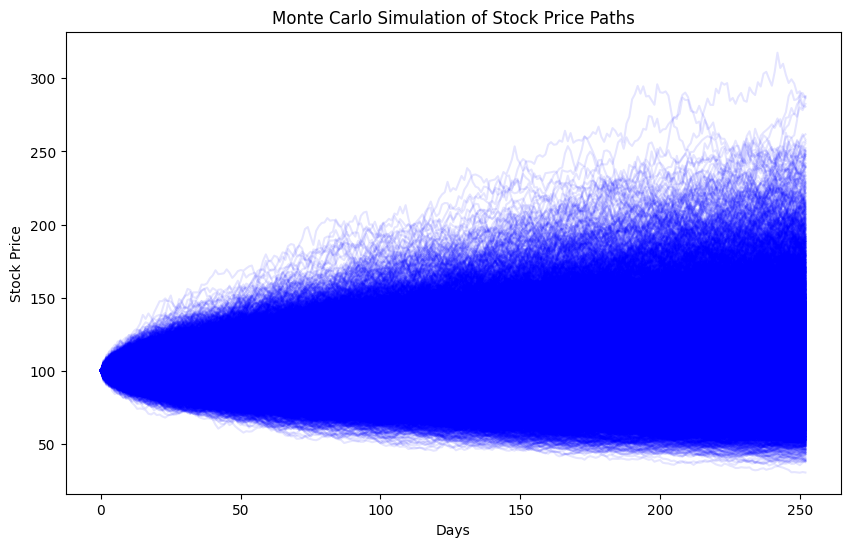

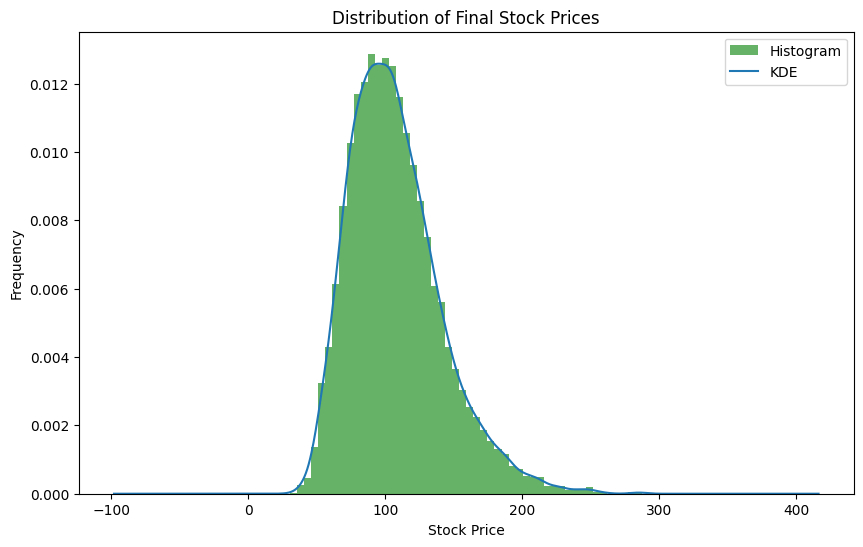

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the default sheet
file_path = 'Daily_Total_Returns.xlsx'
daily_returns_data = pd.read_excel(file_path)

# Extract the returns column
all_daily_returns = daily_returns_data['Daily Total Returns']

# Convert to decimal
all_daily_returns = all_daily_returns / 100

# Parameters
S0 = 100  # initial stock price
T = 252  # time horizon in days (1 year)
N = 252  # number of steps
simulations = 10000  # number of simulations

# Calculate daily return statistics
mu = np.mean(all_daily_returns)
sigma = np.std(all_daily_returns)

# Simulation
dt = T / N
price_paths = np.zeros((N + 1, simulations))
price_paths[0] = S0

for t in range(1, N + 1):
    rand = np.random.standard_normal(simulations)
    price_paths[t] = price_paths[t-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)

# Final prices
final_prices = price_paths[-1]

# Summary statistics
mean_final_price = np.mean(final_prices)
median_final_price = np.median(final_prices)
std_final_price = np.std(final_prices)
min_final_price = np.min(final_prices)
max_final_price = np.max(final_prices)

print(f"Mean final price: {mean_final_price}")
print(f"Median final price: {median_final_price}")
print(f"Standard deviation of final price: {std_final_price}")
print(f"Minimum final price: {min_final_price}")
print(f"Maximum final price: {max_final_price}")

# Probability of loss
prob_loss = np.mean(final_prices < S0)
print(f"Probability of loss: {prob_loss * 100:.2f}%")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(price_paths, alpha=0.1, color='blue')
plt.title('Monte Carlo Simulation of Stock Price Paths')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

# Histogram and KDE of final prices
plt.figure(figsize=(10, 6))
plt.hist(final_prices, bins=50, density=True, alpha=0.6, color='g', label='Histogram')
final_prices_series = pd.Series(final_prices)
final_prices_series.plot.kde(label='KDE')
plt.title('Distribution of Final Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## **Volatility Modeling**

In [ ]:
!pip install arch

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002779. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3620.62
Distribution:                  Normal   AIC:                          -7233.23
Method:            Maximum Likelihood   BIC:                          -7212.58
                                        No. Observations:                 1292
Date:                Mon, Jul 29 2024   Df Residuals:                     1291
Time:                        15:27:46   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.2257e-05  2.476e-04  8.990e-02      0.928 

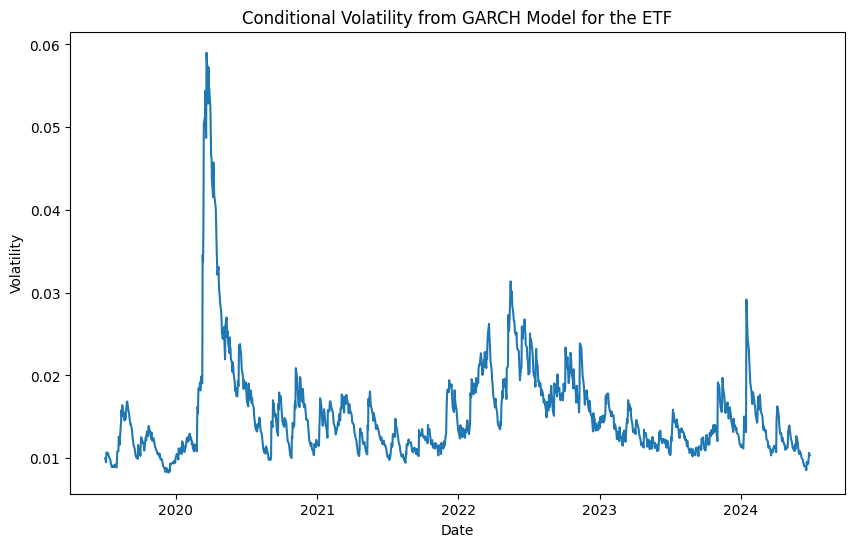

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Load the stock data from the Excel file
file_path = 'Stock_Data.xlsx'
stock_data = pd.read_excel(file_path, sheet_name='Stock_Data')

# Parse the Date column to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], dayfirst=True, errors='coerce')

# Drop any rows where date conversion failed
stock_data.dropna(subset=['Date'], inplace=True)

# Set the Date as the index
stock_data.set_index('Date', inplace=True)

# Calculate daily returns for each asset
stock_data['Returns'] = stock_data.groupby('Symbol')['Adj Close'].pct_change()

# Drop any NaN values created by the pct_change() function
returns = stock_data.dropna(subset=['Returns'])

# Aggregate the returns to get the overall ETF return
returns_pivot = returns.pivot(columns='Symbol', values='Returns')
etf_returns = returns_pivot.mean(axis=1)

# Fit a GARCH(1,1) model to the ETF returns
garch_model = arch_model(etf_returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Print the summary of the GARCH model fit
print(garch_result.summary())

# Plot the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(garch_result.conditional_volatility)
plt.title('Conditional Volatility from GARCH Model for the ETF')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2024-06-28  0.001598  0.001625  0.001652  0.001677  0.001702  0.001726   

                h.07      h.08      h.09      h.10  ...      h.21      h.22  \
Date                                                ...                       
2024-06-28  0.001749  0.001772  0.001793  0.001814  ...  0.002008  0.002023   

                h.23      h.24      h.25      h.26      h.27      h.28  \
Date                                                                     
2024-06-28  0.002037  0.002051  0.002065  0.002078  0.002091  0.002103   

                h.29      h.30  
Date                            
2024-06-28  0.002115  0.002127  

[1 rows x 30 columns]


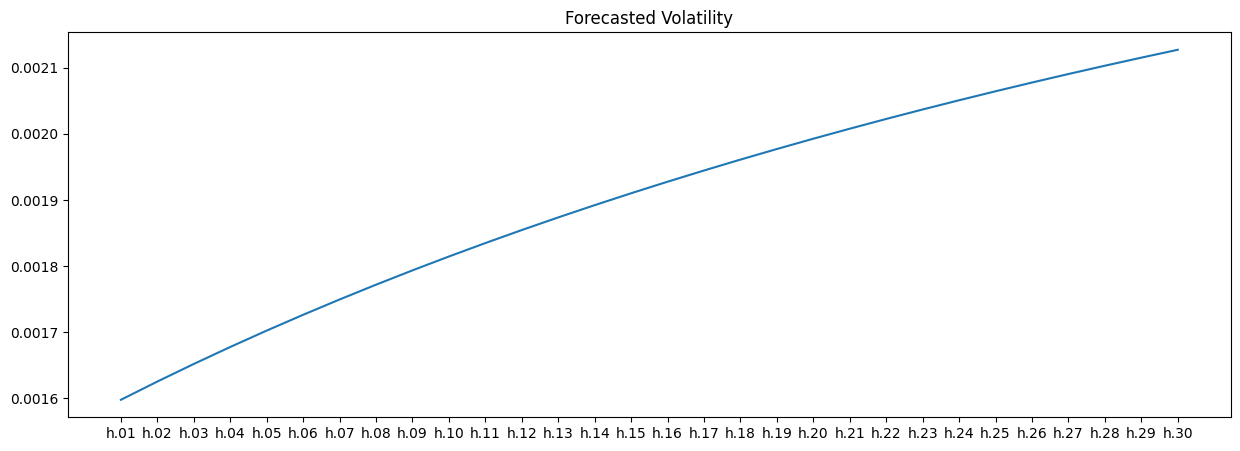

In [ ]:
# Forecast future volatility
forecast_horizon = 30
forecasts = garch_result.forecast(horizon=forecast_horizon)
#Compute volatility - remove the return scaling and scale to annual terms
volat_forecast = ((forecasts.variance[-1:]/(100**2))*252)**0.5
print(volat_forecast)

# Plot the forecasted volatility
plt.figure(figsize=(15, 5))
plt.plot(volat_forecast.iloc[-1])
plt.title('Forecasted Volatility')
plt.show()

Historical Volatility:
 Symbol
ADM      0.019036
AGCO     0.024844
BABYF    0.072084
BG       0.020921
BYND     0.049507
CMG      0.022154
CNH      0.025615
CPNG     0.037057
DE       0.020791
INGR     0.017748
LMND     0.053625
LNN      0.023527
LWAY     0.048511
NTR      0.023583
OLO      0.040138
QSR      0.019912
RGF      0.062109
STKL     0.040784
TKWY     0.033799
TRMB     0.023839
TSN      0.019962
TTC      0.018347
UBER     0.034341
VFF      0.052035
WTRH     0.108521
YUM      0.016422
Name: Returns, dtype: float64
Correlation Matrix of Returns:
 Symbol       ADM      AGCO     BABYF        BG      BYND       CMG       CNH  \
Symbol                                                                         
ADM     1.000000  0.532086  0.113431  0.701926  0.123767  0.220464  0.497806   
AGCO    0.532086  1.000000  0.119947  0.548949  0.202881  0.364663  0.707024   
BABYF   0.113431  0.119947  1.000000  0.125755  0.082204  0.159812  0.098406   
BG      0.701926  0.548949  0.125755  1

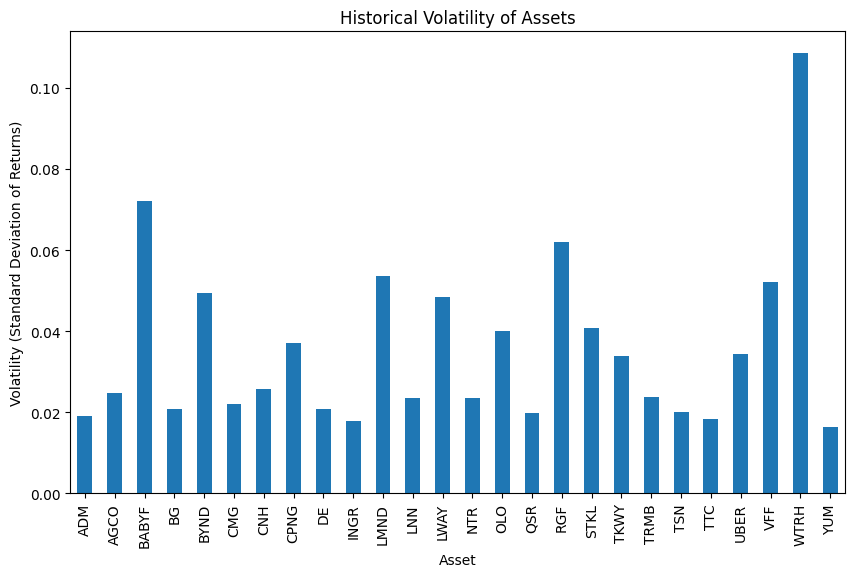

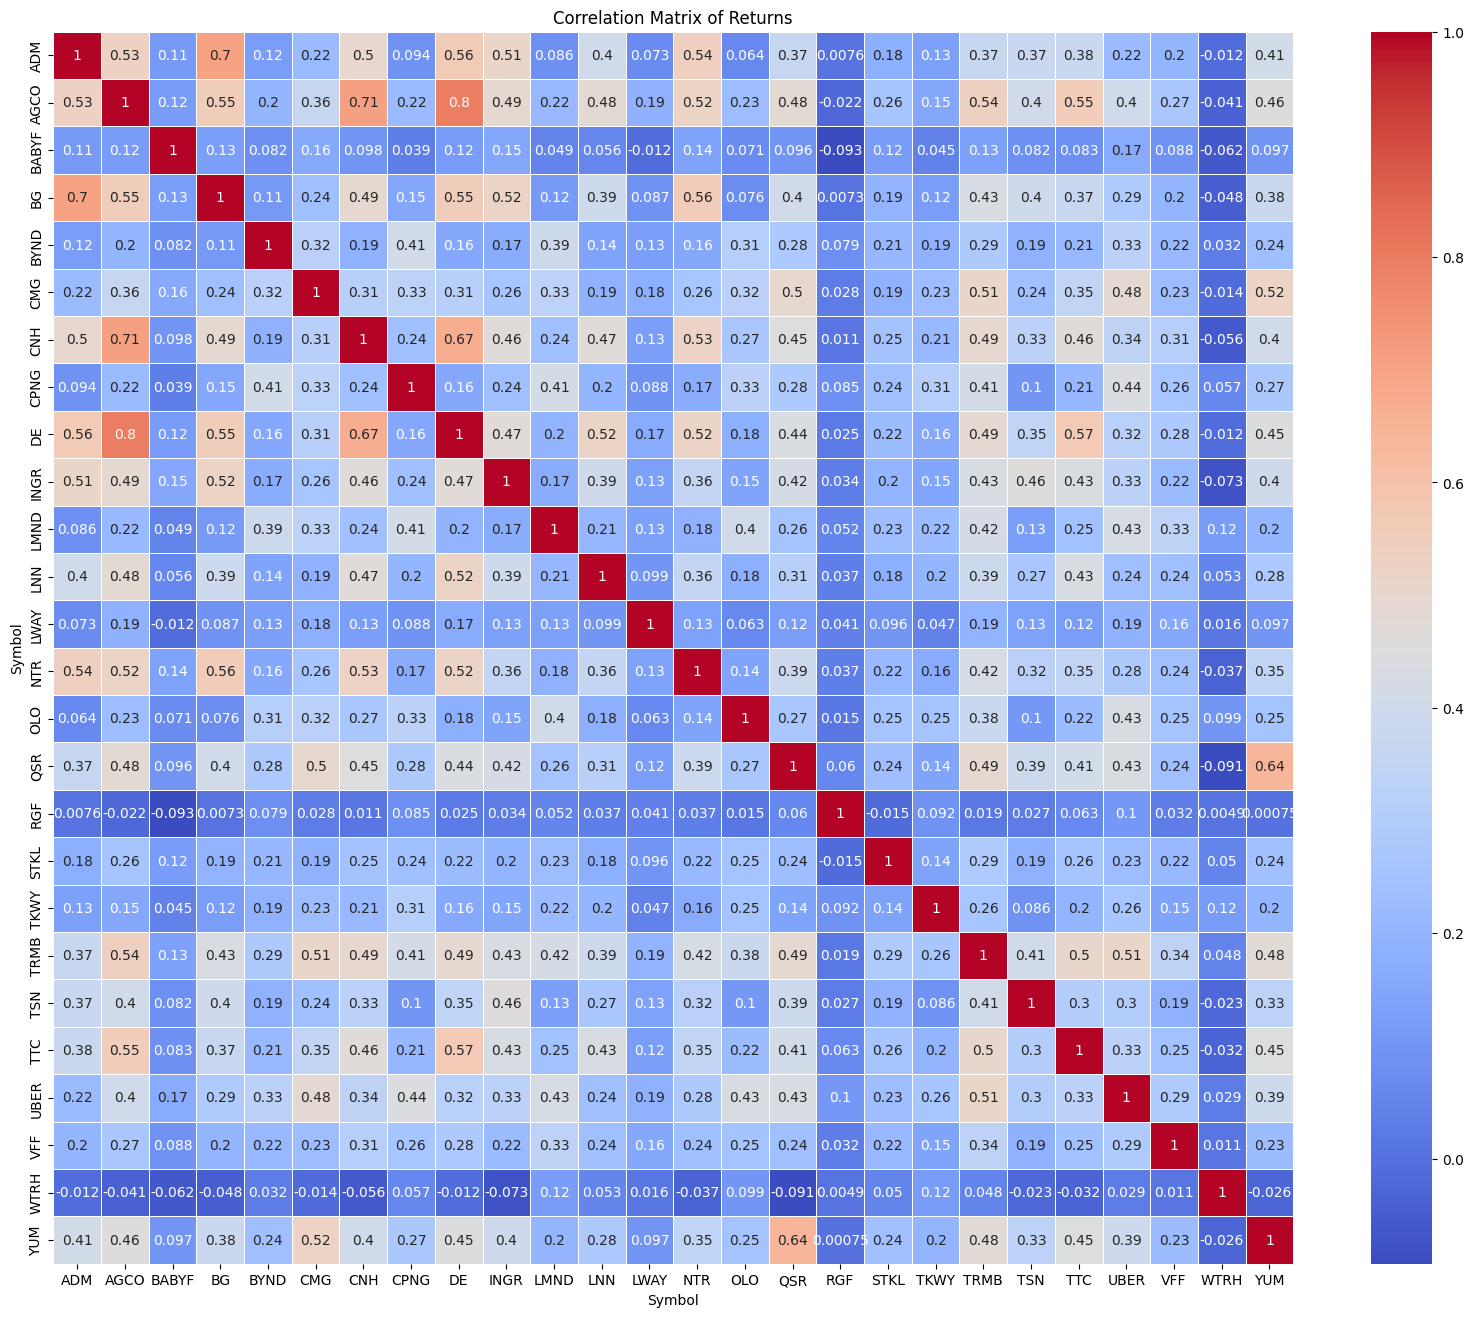

In [ ]:
import seaborn as sns
# Historical Volatility of Assets and Correlation Matrix of Returns

# Load relevant sheet into a DataFrame
stock_data = pd.read_excel(file_path, sheet_name='Stock_Data')

# Parse the Date column to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], dayfirst=True, errors='coerce')

# Drop any rows where date conversion failed
stock_data.dropna(subset=['Date'], inplace=True)

# Set the Date as the index
stock_data.set_index('Date', inplace=True)

# Calculate daily returns for each asset
stock_data['Returns'] = stock_data.groupby('Symbol')['Adj Close'].pct_change()

# Drop any NaN values created by the pct_change() function
returns = stock_data.dropna(subset=['Returns'])

# Calculate historical volatility (standard deviation of returns) for each asset
volatility = returns.groupby('Symbol')['Returns'].std()

# Print the historical volatility
print("Historical Volatility:\n", volatility)

# Pivot the returns data to get a matrix of returns with dates as rows and assets as columns
returns_pivot = returns.pivot(columns='Symbol', values='Returns')

# Calculate the correlation matrix of returns
correlation_matrix = returns_pivot.corr()

# Print the correlation matrix
print("Correlation Matrix of Returns:\n", correlation_matrix)

# Plot the historical volatility
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.title('Historical Volatility of Assets')
plt.xlabel('Asset')
plt.ylabel('Volatility (Standard Deviation of Returns)')
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(
correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Returns')
plt.show()